# Descrição do problema
O dataset contém dados de clientes que entraram em churn em 2 meses e o objetvo do case é identificar clientes com potencial de churn para realizar ações preventivas afim de diminuir o custo da perda de clientes

O notebook foi dividido em:
* **EDA (Exporatory Data Analysis)**: Análise descritiva dos dados
* **Modelagem**: Modelagem do dataset para identificar churn
* **Resultados**: Avaliação dos resultados
    * **Test**: Avaliação da `ROC_AUC`, `RECALL` e `ACCURACY` na base de teste
    * **Feature Importance**: Identificação das variáveis mais importantes
    * **Threshold**: Limiar ótimo para maiores `ROC_AUC`, `RECALL` e `ACCURACY`
* **Custo do churn**: Criação da matrix de custo e função de custo
* **Conclusão**: Avaliação do modelo otimizado para minimização de custo de churn

### Importings

Importando libs que usarei ao longo do notebook

In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
import xgboost as xbg
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from tpot import TPOTClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import itertools
import warnings
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
df = pd.read_csv('dataset_churn.csv')

### EDA (Exploratory Data Analysis)

In [3]:
df.shape

(10000, 11)

Antes de começar a manipular os dados, otimizarei o uso de memória, redefinindo os tipos de cada variável. Dessa forma, consegui diminuir o uso da memória em 42%

In [3]:
def memory_optimize(df):
    memory_0 = df.memory_usage().sum()
    
    df = df.astype({'Score Crédito': 'int32',
                    'Estado': 'category',
                    'Gênero': 'category',
                    'Idade': 'int32',
                    'Tempo como cliente (meses)': 'int32',
                    'Número de produtos': 'int32',
                    'Possui Cartao de Crédito': 'uint8',
                    'Assina mensalidade': 'uint8',
                    'Churn_2_meses': 'uint8'})
    
    memory_1 = df.memory_usage().sum()
    print(f'Reducing {round(memory_1/memory_0 * 100, 2)}% of memory')
    return df

In [4]:
df = memory_optimize(df)

Reducing 42.08% of memory


Podemos ver que a target `Churn_2_meses` é desbalanceada, sendo que `20%` das pessoas na base _churnaram_

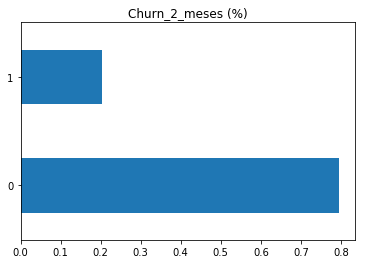

In [8]:
df['Churn_2_meses'].value_counts(normalize=True).plot.barh(title='Churn_2_meses (%)')
plt.show()

À seguir plotarei a distribuição de cada variável para clientes que _churnaram_ e que continuam na base

<Figure size 432x288 with 0 Axes>

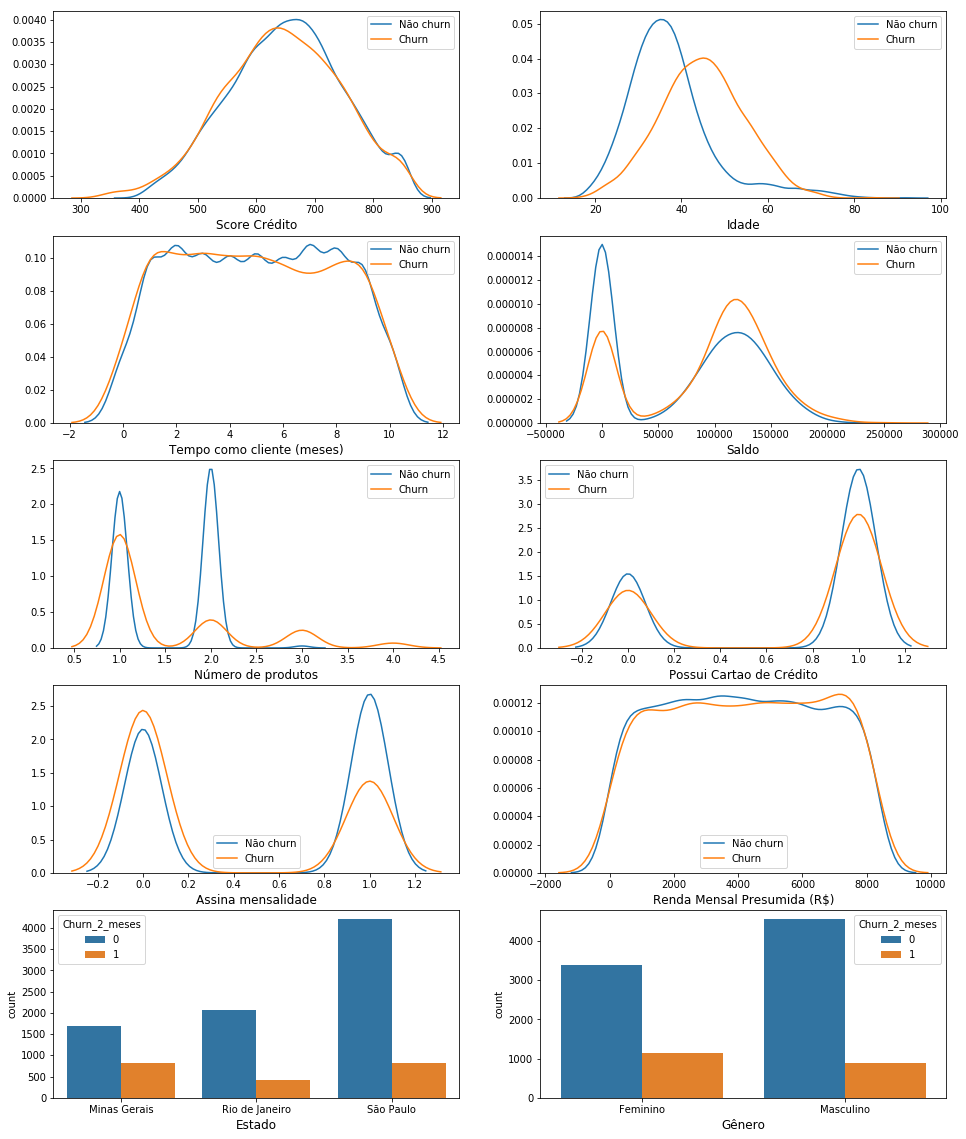

In [9]:
def plot_distributions(df):
    cols_num = df.select_dtypes(exclude='category').columns.tolist()
    cols_num.remove('Churn_2_meses')
    cols_cat = df.select_dtypes(include='category').columns.tolist()
    
        
    df_nao_churn = df.query('Churn_2_meses == 0')
    df_churn = df.query('Churn_2_meses == 1')

    plt.figure()
    fig, ax = plt.subplots(5, 2, figsize=(16, 20))
    
    i = 0
    for col in cols_num:
        i += 1
        plt.subplot(5, 2, i)
        sns.kdeplot(df_nao_churn[col],label="Não churn")
        sns.kdeplot(df_churn[col], label="Churn")
        plt.xlabel(col, fontsize=12)
                
    for col in cols_cat:
        i += 1
        plt.subplot(5, 2, i)
        sns.countplot(x=col,hue='Churn_2_meses', data=df)
        plt.xlabel(col, fontsize=12)
            
    plt.show()
    
plot_distributions(df)

Abaixo plotei pares de algumas variáveis númericas que pudesse nos ajudar a identificar se combinadas, poderiam ajudar a discriminar o churn de clientes

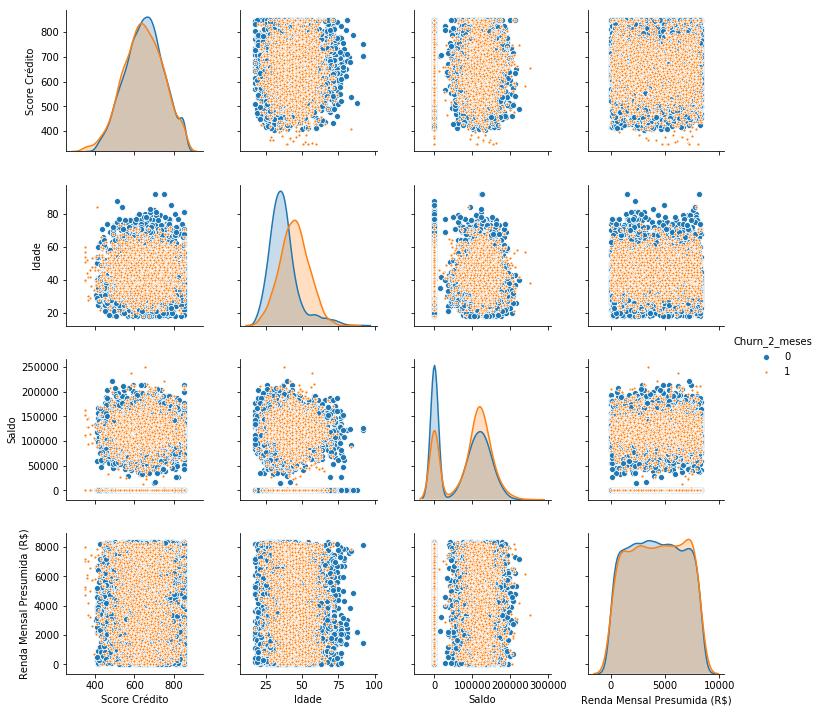

In [10]:
pair_cols = ['Score Crédito', 'Idade', 'Saldo', 'Renda Mensal Presumida (R$)']

sns.pairplot(df, vars=pair_cols, hue='Churn_2_meses', markers=['o', '.'])
plt.show()

Para verificar se há variáveis correlacionadas, construi o heatmp com correlação de pearson entre as variáveis conforme abaixo

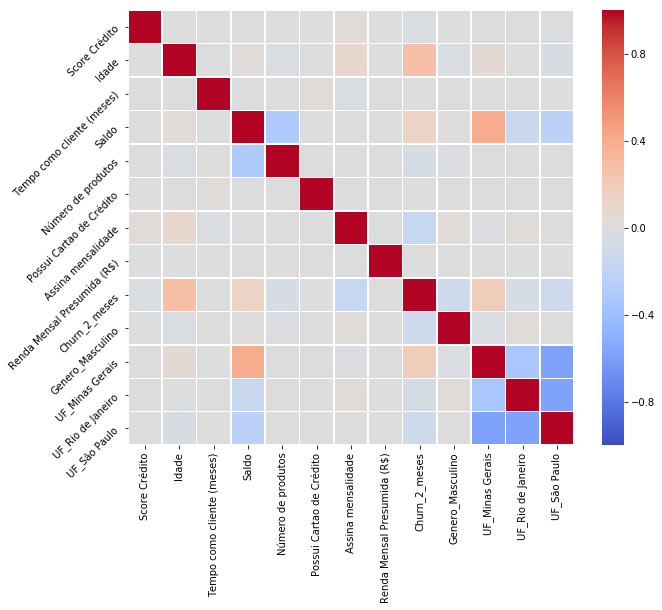

In [299]:
def plot_heatmap(df):
    df = pd.get_dummies(df, columns=['Gênero', 'Estado'], prefix=['Genero', 'UF']).drop('Genero_Feminino', axis=1)
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), vmin=-1, cmap='coolwarm', linewidths=.5)
    plt.xticks(rotation=90)
    plt.yticks(rotation=45)
    plt.show()
    
plot_heatmap(df)

Aparentemente a correlação entre as variáveis é baixa e manterei a base para a próxima etapa de modelagem

### Modelagem

As variáveis categóricas `Estado` e `Gênero` foram tratadas com `one hot encoding` e as numéricas `Score Crédito`, `Idade`, `Tempo como cliente (meses)`, `Saldo`, `Número de produtos`, `Possui Cartao de Crédito`, `Assina mensalidade` e `Renda Mensal Presumida (R$)` foram normalizadas com `MinMaxScaler` para manterem a mesma escala.

Para balancear os dados, testei os algoritmos `Random_under_sampler`, `Random_over_sampler` e `SMOTE`.

E para a escolha dos algoritmos de classificação, utilizei 7 modelos simples (`Logistic Regression`, `KNN`, `Decision Tree`, `Random Forest`, `AdaBoost`, `SVM` e `MLP`); `XGBoost` com otimização de hiperparâmetros com `Random Search` e `cross validation = 5`; e `TPOT` para avaliar outros eventuais classificadores que pudessem oferecer melhor performance.

Todos os pipelines utilizam os 3 `samplers` (`Random_under_sampler`, `Random_over_sampler` e `SMOTE`), com exceção do `XGBoost` que tem o parâmetro `scale_pos_weight` que considera o desbalanceamento da base no treinamento.

No final, obtive `25` pipelines

#### Simple classifiers

In [7]:
classifiers = {'Logistic Regression' : LogisticRegression(),
               'KNN': KNeighborsClassifier(),
               'Decision Tree': DecisionTreeClassifier(),
               'Random Forest': RandomForestClassifier(),
               'AdaBoost': AdaBoostClassifier(),
               'SVM': SVC(),
               'MLP': MLPClassifier()}

samplers = {'Random_under_sampler': RandomUnderSampler(),
            'Random_over_sampler': RandomOverSampler(),
            'SMOTE': SMOTE()}

col_scaler = ['Score Crédito', 'Idade', 'Tempo como cliente (meses)', 'Saldo', 'Número de produtos', 'Possui Cartao de Crédito', 'Assina mensalidade', 'Renda Mensal Presumida (R$)']
col_categ = ['Gênero', 'Estado']

In [8]:
def df_split(df, target='Churn_2_meses'):
    x = df.drop(target, axis=1)
    y = df[target]    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)                          
    return x_train, x_test, y_train, y_test

In [9]:
def train_clfs(df, classifiers, samplers, col_scaler, col_categ):
    
    x_train, x_test, y_train, y_test = df_split(df)
    
    names_samplers = []
    names_clfs = []
    results_train_cv_roc_auc = []
    results_train_cv_recall = []
    results_train_cv_accuracy = []
    results_test_roc_auc = []
    results_test_recall = []
    results_test_accuracy = []
    
    preprocess = make_column_transformer((MinMaxScaler(), col_scaler),
                                         (OneHotEncoder(drop='first'), col_categ))
        
    for name_sampler, sampler in samplers.items():
        print(f'Sampler: {name_sampler}\n')
        for name_clf, clf in classifiers.items():
            print(f'Classifier: {name_clf}\n')
            
            pipeline = Pipeline([('preprocess', preprocess),
                                 ('sampler', sampler),
                                 ('clf', clf)])
            
            cv_auc = cross_val_score(pipeline, x_train, y_train, cv=10, scoring='roc_auc') 
            cv_rec = cross_val_score(pipeline, x_train, y_train, cv=10, scoring='recall')                                
            cv_acc = cross_val_score(pipeline, x_train, y_train, cv=10, scoring='accuracy')        

            pipeline.fit(x_train, y_train)        
            y_pred = pipeline.predict(x_test)
            
            names_samplers.append(name_sampler)
            names_clfs.append(name_clf)
            results_train_cv_roc_auc.append(cv_auc)
            results_train_cv_recall.append(cv_rec)
            results_train_cv_accuracy.append(cv_acc)
            results_test_roc_auc.append(roc_auc_score(y_test, y_pred))
            results_test_recall.append(recall_score(y_test, y_pred))
            results_test_accuracy.append(accuracy_score(y_test, y_pred))

            print(f'CV\t-\troc_auc:\t{round(cv_auc.mean(), 3)}')
            print(f'CV\t-\trecall:\t\t{round(cv_rec.mean(), 3)}')
            print(f'CV\t-\taccuracy:\t{round(cv_acc.mean(), 3)}')

            print(f'Test\t-\troc_auc:\t{round(roc_auc_score(y_test, y_pred), 3)}')         
            print(f'Test\t-\trecall:\t\t{round(recall_score(y_test, y_pred), 3)}')          
            print(f'Test\t-\taccuracy:\t{round(accuracy_score(y_test, y_pred), 3)}')      
            print('\n<-------------------------->\n')

    df_results_test = pd.DataFrame(index=[names_clfs, names_samplers], columns=['ROC_AUC', 'RECALL', 'ACCURACY'])
    df_results_test['ROC_AUC'] = results_test_roc_auc
    df_results_test['RECALL'] = results_test_recall
    df_results_test['ACCURACY'] = results_test_accuracy

    return df_results_test

In [10]:
df_results_test = train_clfs(df, classifiers, samplers, col_scaler, col_categ)

Sampler: Random_under_sampler

Classifier: Logistic Regression

CV	-	roc_auc:	0.766
CV	-	recall:		0.687
CV	-	accuracy:	0.71
Test	-	roc_auc:	0.709
Test	-	recall:		0.705
Test	-	accuracy:	0.711

<-------------------------->

Classifier: KNN

CV	-	roc_auc:	0.747
CV	-	recall:		0.646
CV	-	accuracy:	0.71
Test	-	roc_auc:	0.674
Test	-	recall:		0.649
Test	-	accuracy:	0.689

<-------------------------->

Classifier: Decision Tree

CV	-	roc_auc:	0.696
CV	-	recall:		0.688
CV	-	accuracy:	0.692
Test	-	roc_auc:	0.703
Test	-	recall:		0.705
Test	-	accuracy:	0.702

<-------------------------->

Classifier: Random Forest

CV	-	roc_auc:	0.85
CV	-	recall:		0.753
CV	-	accuracy:	0.782
Test	-	roc_auc:	0.767
Test	-	recall:		0.757
Test	-	accuracy:	0.774

<-------------------------->

Classifier: AdaBoost

CV	-	roc_auc:	0.841
CV	-	recall:		0.74
CV	-	accuracy:	0.773
Test	-	roc_auc:	0.775
Test	-	recall:		0.774
Test	-	accuracy:	0.776

<-------------------------->

Classifier: SVM

CV	-	roc_auc:	0.809
CV	-	recall:		0

In [301]:
df_results_test.shape

(21, 3)

#### XGBoost with random search

In [33]:
def train_xgb(df, clf, col_scaler, col_categ):
    
    x_train, x_test, y_train, y_test = df_split(df)

    scale_pos_weight = len(df.query('Churn_2_meses == 0')) / len(df.query('Churn_2_meses == 1'))


    preprocess = make_column_transformer((MinMaxScaler(), col_scaler),
                                         (OneHotEncoder(drop='first'), col_categ))

    param_grid = {'xgb__max_depth': [3, 4, 5, 6, 7, 8],
                  'xgb__learning_rate': [0.01, 0.05, 0.1, 0.2],
                  'xgb__colsample_bytree': [0.6, 0.7, 0.8],
                  'xgb__min_child_weight': [0.4, 0.5, 0.6],
                  'xgb__gamma': [0, 0.01, 0.1],
                  'xgb__reg_lambda': [6, 7, 8, 9, 10],
                  'xgb__n_estimators': [150, 200, 300],
                  'xgb__scale_pos_weight': [scale_pos_weight]}


    pipeline_xgb = Pipeline([('preprocess', preprocess),
                             ('xgb', clf)])

    rs_clf = RandomizedSearchCV(pipeline_xgb, param_grid, n_iter=100,
                                n_jobs=-1, verbose=2, cv=5,                            
                                scoring='roc_auc', random_state=42)

    rs_clf.fit(x_train, y_train)
    
    print(f'XGBOOST BEST PARAMS: {rs_clf.best_params_}')
    
    y_pred = rs_clf.predict(x_test)

    df_results_xgb = pd.DataFrame(index=[['XGBoost'], ['No_sampler']], columns=['ROC_AUC', 'RECALL', 'ACCURACY'])

    df_results_xgb['ROC_AUC'] = roc_auc_score(y_test, y_pred)
    df_results_xgb['RECALL'] = recall_score(y_test, y_pred)
    df_results_xgb['ACCURACY'] = accuracy_score(y_test, y_pred)
    
    return df_results_xgb

In [34]:
df_results_xgb = train_xgb(df, xgb.XGBClassifier(), col_scaler, col_categ)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.4min finished


XGBOOST BEST PARAMS: {'xgb__scale_pos_weight': 3.9091801669121256, 'xgb__reg_lambda': 7, 'xgb__n_estimators': 150, 'xgb__min_child_weight': 0.5, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0, 'xgb__colsample_bytree': 0.8}


#### TPOT

In [37]:
tpot = TPOTClassifier(generations=10, population_size=100, early_stop=5,
                      scoring='roc_auc', verbosity=2)

In [53]:
def train_tpot(df, tpot, samplers, col_scaler, col_categ):
    
    x_train, x_test, y_train, y_test = df_split(df)
    
    names_samplers = []
    names_clfs = []
    results_test_roc_auc = []
    results_test_recall = []
    results_test_accuracy = []
    
    preprocess = make_column_transformer((MinMaxScaler(), col_scaler),
                                         (OneHotEncoder(drop='first'), col_categ))
        
    for name_sampler, sampler in samplers.items():
        print(f'Sampler: {name_sampler}\n')        
            
        pipeline = Pipeline([('preprocess', preprocess),
                             ('sampler', sampler),
                             ('tpot', tpot)])    
                        
        pipeline.fit(x_train, y_train)
        
        pipeline['tpot'].export(name_sampler + '_tpot.py')
        
        y_pred = pipeline.predict(x_test)

        names_samplers.append(name_sampler)
        names_clfs.append('tpot')
        results_test_roc_auc.append(roc_auc_score(y_test, y_pred))
        results_test_recall.append(recall_score(y_test, y_pred))
        results_test_accuracy.append(accuracy_score(y_test, y_pred))

        print(f'Test\t-\troc_auc:\t{round(roc_auc_score(y_test, y_pred), 3)}')         
        print(f'Test\t-\trecall:\t\t{round(recall_score(y_test, y_pred), 3)}')          
        print(f'Test\t-\taccuracy:\t{round(accuracy_score(y_test, y_pred), 3)}')      
        print('\n<-------------------------->\n')

    df_results_test = pd.DataFrame(index=[names_clfs, names_samplers], columns=['ROC_AUC', 'RECALL', 'ACCURACY'])
    df_results_test['ROC_AUC'] = results_test_roc_auc
    df_results_test['RECALL'] = results_test_recall
    df_results_test['ACCURACY'] = results_test_accuracy

    return df_results_test

In [55]:
df_results_tpot = train_tpot(df, tpot, samplers, col_scaler, col_categ)

In [87]:
df_results = pd.concat([df_results_test, df_results_xgb, df_results_tpot])

### Resultados

#### Test

Podemos observar a performance dos classificadores pelo `ROC_AUC`, `RECALL` e `ACCURACY` na base de teste.

Abaixo plotei os 2 melhores pipelines para cada métrica : `ROC_AUC`, `RECALL` e `ACCURACY`

In [93]:
df_plot = pd.concat([df_results.sort_values('ROC_AUC', ascending=False).head(2),
                     df_results.sort_values('RECALL', ascending=False).head(2),
                     df_results.sort_values('ACCURACY', ascending=False).head(2)])

In [100]:
def plot_test(df, xlim_min, xlim_max):

    f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10,12))

    color = ['blue', 'red', 'green', 'yellow', 'orange', 'purple']

    df['ROC_AUC'].plot(kind='barh', ax=ax1, xlim=(xlim_min, xlim_max), title='ROC_AUC', color=color)
    df['RECALL'].plot(kind='barh', ax=ax2, xlim=(xlim_min, xlim_max), title='RECALL', color=color)
    df['ACCURACY'].plot(kind='barh', ax=ax3, xlim=(xlim_min, xlim_max), title='ACCURACY', color=color)
    plt.show()

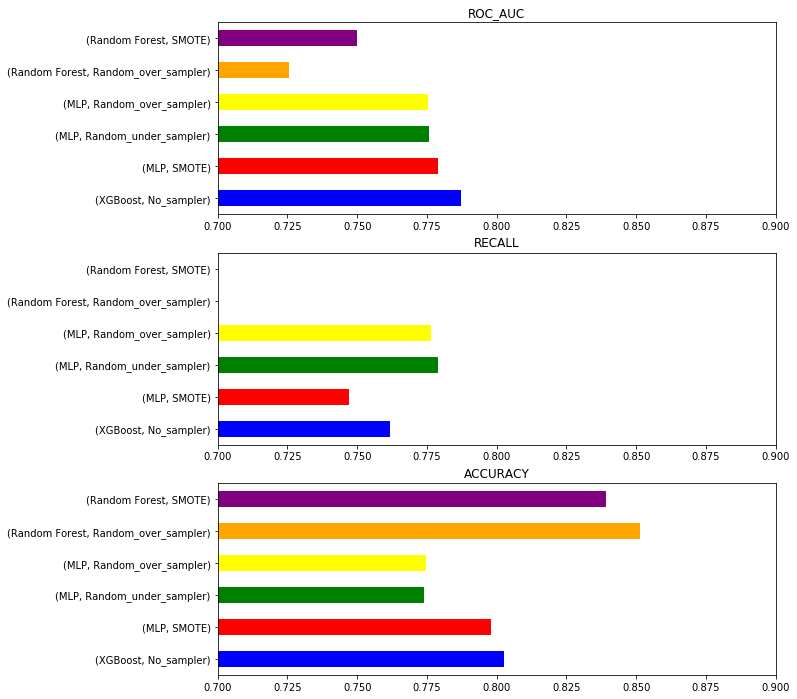

In [102]:
plot_test(df_plot, 0.7, 0.9)

Por ser um modelo de churn, um modelo que oferece maior `RECALL` é melhor que `ACCURACY`, visto que queremos diminuir o número de falso negativos na base. Explicarei isso mais detalhadamente abaixo.

Pela performance dos pipelines, escolhi o pipeline `MLP + Random Under Sampler` (melhor `ROC_AUC`) e `XGBoost` (melhor `RECALL`) para avaliar a performance na otimização de custo do modelo de churn.

#### Feature Importance

Identificar as variáveis mais importantes para a previsão do churn pode auxiliar os tomadores de decisão com insights de negócios.

Abaixo utilizei `permutation importance` nos pipelines `MLP + Random Under Sampler` e `XGBoost` para identificar as principais variáveis para o modelo

In [238]:
def explainer(df, clf, col_scaler, col_categ, sampler=None):
            
    preprocess = make_column_transformer((MinMaxScaler(), col_scaler),
                                         (OneHotEncoder(drop='first'), col_categ))
    
    if sampler:
        
        df_prep = preprocess.fit_transform(df)
        fnames = col_scaler + preprocess.named_transformers_['onehotencoder'].get_feature_names().tolist()
        df_prep = pd.DataFrame(df_prep, columns=fnames)
        df_prep['Churn_2_meses'] = df['Churn_2_meses']
        
        x_train, x_test, y_train, y_test = df_split(df_prep)
                
        pipeline = Pipeline([('sampler', sampler), ('clf', clf)])
        
        pipe = pipeline.fit(x_train, y_train)
        perm = PermutationImportance(pipe, random_state=1).fit(x_test, y_test)
        return perm, x_test.columns.tolist()
    
    else:      
        
        x_train, x_test, y_train, y_test = df_split(df)        
        pipeline = Pipeline([('preprocess', preprocess),
                             ('clf', clf)])
                                
        pipeline.fit(x_train, y_train)
        
        fnames = col_scaler + pipeline['preprocess'].named_transformers_['onehotencoder'].get_feature_names().tolist()

        return pipeline.steps[-1][1], fnames

In [242]:
explainer, fnames = explainer(df, MLPClassifier(), col_scaler, col_categ, sampler=RandomUnderSampler())

In [243]:
show_weights(explainer, feature_names = fnames)

Weight,Feature
0.1160 ± 0.0160,Número de produtos
0.0649 ± 0.0164,Idade
0.0429 ± 0.0088,Saldo
0.0338 ± 0.0159,x1_São Paulo
0.0297 ± 0.0085,x1_Rio de Janeiro
0.0176 ± 0.0045,Assina mensalidade
0.0089 ± 0.0018,x0_Masculino
0.0048 ± 0.0038,Tempo como cliente (meses)
0.0029 ± 0.0081,Renda Mensal Presumida (R$)
0.0029 ± 0.0037,Possui Cartao de Crédito


In [233]:
scale_pos_weight = len(df.query('Churn_2_meses == 0')) / len(df.query('Churn_2_meses == 1'))

xgbclf = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, reg_lambda=7, n_estimators=150, min_child_weight=0.5,
                  max_depth=5, learning_rate=0.05, gamma=0, colsample_bytree=0.8)

xplainer, fnames = explainer(df, xgbclf, col_scaler, col_categ)

In [241]:
show_weights(xplainer, feature_names=fnames)

Weight,Feature
0.3034,Número de produtos
0.1808,Assina mensalidade
0.1629,Idade
0.0774,x1_São Paulo
0.0687,Saldo
0.0613,x1_Rio de Janeiro
0.0571,x0_Masculino
0.0242,Score Crédito
0.0236,Renda Mensal Presumida (R$)
0.0215,Tempo como cliente (meses)


O `número de produtos` é uma variável comum em grau de importância para ambos modelos, assim como a `idade` que apresenta um peso significativo na previsão.

Já a `renda mensal presumida` e `possui cartão de crédito` não parecem surtir efeito para previsão do modelo.

#### Threshold

Outra forma de classificar o cliente com churn ou não é utililzar o `predict_proba` dos classificadores escolhidos e variar o limiar `threshold` entre `0 a 1`, variando a previsão da classificação do target 

In [245]:
def plot_confusion_matrix(y_test, y_pred, title='Confusion matrix'):
    
    cm = confusion_matrix(y_test, y_pred)
    classes = ['Não Churn', 'Churn']

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, )
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# cria matrix de confusão para cada threshold
def train_clf_threshold(df, clf, sampler=None):
    thresholds = np.arange(0.1, 1, 0.1)
    
    x_train, x_test, y_train, y_test = df_split(df)
    preprocess = make_column_transformer((MinMaxScaler(), col_scaler),
                                         (OneHotEncoder(drop='first'), col_categ))
    
    if sampler:
        pipeline = Pipeline([('preprocess', preprocess),
                             ('sampler', sampler),
                             ('clf', clf)])
        
    else:        
        pipeline = Pipeline([('preprocess', preprocess),
                             ('clf', clf)])
        
    
    pipeline.fit(x_train, y_train)
    y_proba = pipeline.predict_proba(x_test)
    
    plt.figure(figsize=(10,10))

    j = 1
    for i in thresholds:
        y_pred = y_proba[:,1] > i

        plt.subplot(4, 3, j)
        j += 1

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_test,y_pred)
        np.set_printoptions(precision=2)

        print(f"Threshold: {round(i, 1)} | Test Recall: {round(recall_score(y_test, y_pred), 2)} | Test Roc Auc: {round(roc_auc_score(y_test, y_pred), 2)}")

        # Plot non-normalized confusion matrix
        plot_confusion_matrix(y_test, y_pred, title=f'Threshold >= {round(i, 1)}')

Threshold: 0.1 | Test Recall: 0.98 | Test Roc Auc: 0.62
Threshold: 0.2 | Test Recall: 0.93 | Test Roc Auc: 0.7
Threshold: 0.3 | Test Recall: 0.87 | Test Roc Auc: 0.74
Threshold: 0.4 | Test Recall: 0.82 | Test Roc Auc: 0.77
Threshold: 0.5 | Test Recall: 0.75 | Test Roc Auc: 0.78
Threshold: 0.6 | Test Recall: 0.67 | Test Roc Auc: 0.77
Threshold: 0.7 | Test Recall: 0.54 | Test Roc Auc: 0.74
Threshold: 0.8 | Test Recall: 0.4 | Test Roc Auc: 0.68
Threshold: 0.9 | Test Recall: 0.25 | Test Roc Auc: 0.62


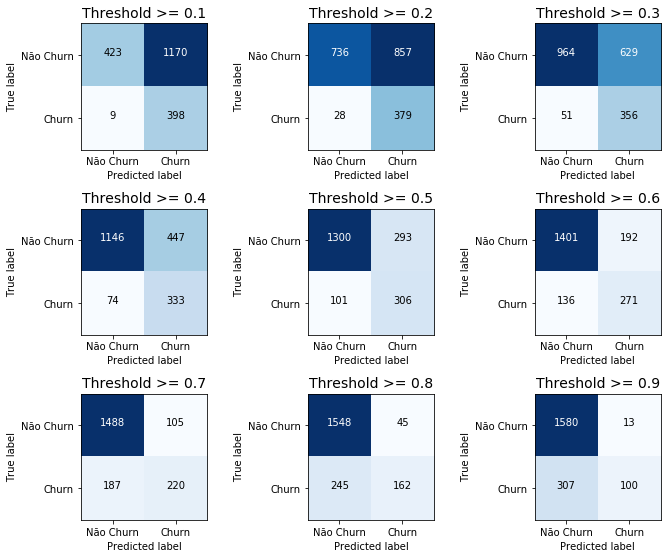

In [246]:
train_clf_threshold(df, MLPClassifier(), sampler=RandomUnderSampler())

Threshold: 0.1 | Test Recall: 0.98 | Test Roc Auc: 0.6
Threshold: 0.2 | Test Recall: 0.94 | Test Roc Auc: 0.69
Threshold: 0.3 | Test Recall: 0.88 | Test Roc Auc: 0.74
Threshold: 0.4 | Test Recall: 0.83 | Test Roc Auc: 0.78
Threshold: 0.5 | Test Recall: 0.76 | Test Roc Auc: 0.79
Threshold: 0.6 | Test Recall: 0.66 | Test Roc Auc: 0.77
Threshold: 0.7 | Test Recall: 0.56 | Test Roc Auc: 0.75
Threshold: 0.8 | Test Recall: 0.44 | Test Roc Auc: 0.71
Threshold: 0.9 | Test Recall: 0.27 | Test Roc Auc: 0.63


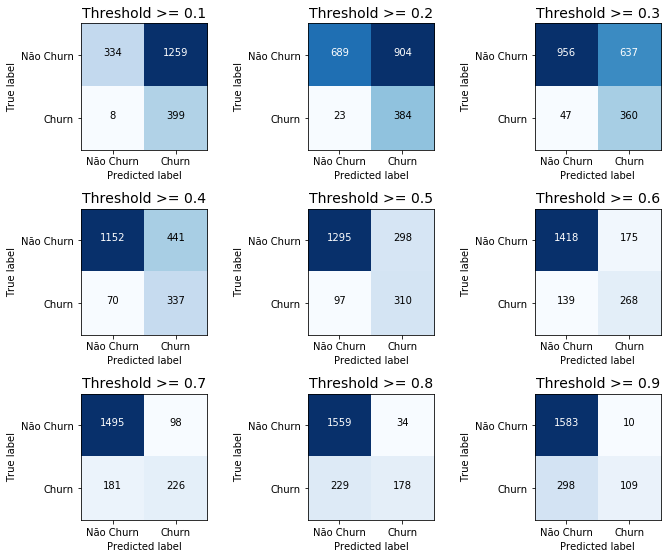

In [247]:
train_clf_threshold(df, xgbclf)

Dessa forma, identificamos que tendo em vista somente o melhor `RECALL`, podemos escolher qualquer dos 2 pipelines com `threshold = 0.1` que obteríamos um `RECALL = 0.98`.

Já caso quiséssemos o melhor `ROC_AUC`, escolheríamos o `XGBoost` com `threshold = 0.5` que obteríamos um `ROC_AUC = 0.79`.

Porém, para avaliar qual é o melhor pipeline e threshold para o negócio, temos que avaliar o custo de cada decisão conforme informado à seguir

### Custo do churn

Para evitar que um cliente _churne_, nós podemos fazer uma oferta `cost_admin` que tem custo administrativo de `R$ 5` e custo da oferta `cost_offer` de `R$ 100` para que o cliente permanece conosco.

Podemos supor que há uma fração de conversão `fraction = 50%` de clientes que não nos deixarão depois de receberem a oferta

Caso o cliente nos deixa, nós perdemos life time value `ltv`, que é a medida da perda de lucro do cliente. Para estimar o `ltv`, podemos inferir que `5%` da renda mensal presumida poderá acarretar em lucro nós, assim, o ltv por cliente seria definido como `sum( renda mensal * 50% ) * mediana do tempo de vida do cliente / número de clientes`

In [319]:
renda_5 = sum(df["Renda Mensal Presumida (R$)"] * 0.05)
tempo_med = df['Tempo como cliente (meses)'].median()
num_clientes = len(df)

print(f'5% da renda mensal: {renda_5}')
print(f'Mediana do tempo de vida do cliente: {tempo_med}')
print(f'Total de clientes na base: {num_clientes}')
print(f'LTV: {renda_5*tempo_med/num_clientes}')      

5% da renda mensal: 2085213.3308541682
Mediana do tempo de vida do cliente: 5.0
Total de clientes na base: 10000
LTV: 1042.6066654270842


No entanto, para fins de arredondamento, podemos assumir o `ltv = R$ 1000`

In [313]:
admin_cost = 5
offer_cost = 100
ltv = 1000

Podemos definir os seguintes conceitos:
* __true negative__: pessoas que o modelo previu que não _churnaram_ e que não _churnaram_ de fato. O custo `cost_true_neg` desses casos é `0`, visto que eles continuam como consumidores e não foi feita nenhuma ação de retenção

* __false positive__: pessoas que o modelo previu que iam _churnar_, quando não _churnaram_. O custo `cost_false_pos` nesse caso é `admin_cost + offer_cost`.

* __false negative__: pessoas que o modelo não previu que iam _churnar_ e não foi enviada nenhuma oferta, mas que _churnaram_. Esse caso oferece o maior custo, sendo `cost_false_neg = ltv`

* __true positive__: pessoas que o modelo previu que iam _churnar_ e que _churnaram_. Esses clientes recebem uma oferta e digamos que se uma fração `fraction` aceite a oferta, o custo `cost_true_pos` será `fraction * offer_cost + (1-fraction) * (ltv + admin_cost)`

Dessa forma, podemos definir a matriz de custo como:

In [314]:
fraction = 0.5

cost_true_neg = 0
cost_false_pos = admin_cost + offer_cost
cost_false_neg = ltv
cost_true_pos = fraction * offer_cost + (1-fraction)*(ltv+admin_cost)

cost = np.array([[cost_true_neg, cost_false_pos],
                 [cost_false_neg, cost_true_pos]])

print(cost)

[[   0.   105. ]
 [1000.   552.5]]


A função de custo médio por pessoa `average_cost` pode ser definida abaixo:

In [339]:
def average_cost(y_test, y_pred, cost):
    c = confusion_matrix(y_test,y_pred)
    score = np.sum(c*cost)/np.sum(c)
    return score

Agora podemos avaliar o custo médio que teríamos por cliente caso um modelo prevesse que ninguém _churnasse_, ou seja, nunca enviaríamos nenhuma oferta

Average cost: 203.7


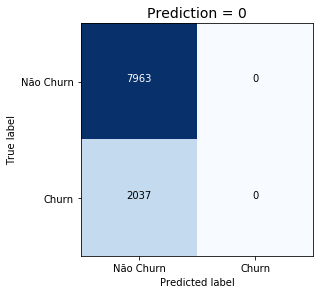

In [343]:
y_pred_0 = np.zeros(len(df), dtype='int')
y_pred_1 = np.ones(len(df), dtype='int')
y_churn = df['Churn_2_meses']

plot_confusion_matrix(y_churn, y_pred_0, title='Prediction = 0')
print(f'Average cost: {average_cost(y_churn, y_pred_0, cost)}')

Ou um modelo que prevesse que o cliente sempre _churnasse_, ou seja, sempre enviaríamos oferta para os clientes

Average cost: 196.15575


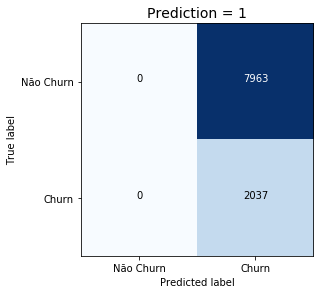

In [344]:
plot_confusion_matrix(y_churn, y_pred_1, title='Prediction = 1')
print(f'Average cost: {average_cost(y_churn, y_pred_1, cost)}')

Dessa forma, o melhor modelo é o que oferece o menor custo, devendo ser menor que o valor de `R$ 196,15`

### Conclusão

Agora que temos a matriz de custo, podemos associar avaliar o custo médio por cliente para cada pipeline e threshold para obter a combinação que ofereça o menor custo de churn

In [354]:
def train_clf_threshold_cost(df, clf, cost, sampler=None):
    thresholds = np.arange(0.1, 1, 0.1)
    
    x_train, x_test, y_train, y_test = df_split(df)
    preprocess = make_column_transformer((MinMaxScaler(), col_scaler),
                                         (OneHotEncoder(drop='first'), col_categ))
    
    if sampler:
        pipeline = Pipeline([('preprocess', preprocess),
                             ('sampler', sampler),
                             ('clf', clf)])
        
    else:        
        pipeline = Pipeline([('preprocess', preprocess),
                             ('clf', clf)])
            
    pipeline.fit(x_train, y_train)
    y_proba = pipeline.predict_proba(x_test)    

    for i in thresholds:
        y_pred = y_proba[:,1] > i
        avg_cost = average_cost(y_test, y_pred, cost)
        print(f"Threshold: {round(i, 1)} | Test Recall: {round(recall_score(y_test, y_pred), 2)} | Test Roc Auc: {round(roc_auc_score(y_test, y_pred), 2)} | Avg cost: {round(avg_cost, 2)}")

In [355]:
train_clf_threshold_cost(df, MLPClassifier(), cost, sampler=RandomUnderSampler())

Threshold: 0.1 | Test Recall: 0.98 | Test Roc Auc: 0.59 | Avg cost: 181.41
Threshold: 0.2 | Test Recall: 0.95 | Test Roc Auc: 0.67 | Avg cost: 168.06
Threshold: 0.3 | Test Recall: 0.9 | Test Roc Auc: 0.72 | Avg cost: 160.84
Threshold: 0.4 | Test Recall: 0.84 | Test Roc Auc: 0.74 | Avg cost: 156.43
Threshold: 0.5 | Test Recall: 0.8 | Test Roc Auc: 0.77 | Avg cost: 152.25
Threshold: 0.6 | Test Recall: 0.7 | Test Roc Auc: 0.76 | Avg cost: 154.46
Threshold: 0.7 | Test Recall: 0.63 | Test Roc Auc: 0.76 | Avg cost: 154.95
Threshold: 0.8 | Test Recall: 0.49 | Test Roc Auc: 0.72 | Avg cost: 162.37
Threshold: 0.9 | Test Recall: 0.32 | Test Roc Auc: 0.65 | Avg cost: 175.24


In [356]:
train_clf_threshold_cost(df, xgbclf, cost)

Threshold: 0.1 | Test Recall: 0.98 | Test Roc Auc: 0.6 | Avg cost: 180.32
Threshold: 0.2 | Test Recall: 0.94 | Test Roc Auc: 0.69 | Avg cost: 165.04
Threshold: 0.3 | Test Recall: 0.88 | Test Roc Auc: 0.74 | Avg cost: 156.39
Threshold: 0.4 | Test Recall: 0.83 | Test Roc Auc: 0.78 | Avg cost: 151.25
Threshold: 0.5 | Test Recall: 0.76 | Test Roc Auc: 0.79 | Avg cost: 149.78
Threshold: 0.6 | Test Recall: 0.66 | Test Roc Auc: 0.77 | Avg cost: 152.72
Threshold: 0.7 | Test Recall: 0.56 | Test Roc Auc: 0.75 | Avg cost: 158.08
Threshold: 0.8 | Test Recall: 0.44 | Test Roc Auc: 0.71 | Avg cost: 165.46
Threshold: 0.9 | Test Recall: 0.27 | Test Roc Auc: 0.63 | Avg cost: 179.64


O melhor pipeline `XGBoost` com `threshold = 0.5` oferece o custo médio por cliente `Avg cost = R$ 149,78`, ou seja, uma diferença de `R$ 46,37`, o que geraria uma redução de custo de `R$ 46,37 * 100.000 = R$ 463.700`